In [1]:
# Load required modules

import numpy as np
import pandas
import scipy.signal

import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import fits

import alias

%matplotlib inline

/mnt_home/jhand/alias/alias/__init__.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
# Open all spectra and combine into a dataset

with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls ]

dataset = alias.loadDataset(files)

# Also load stellar properties from APOGEE and GAIA
table = Table.read('../data/sample.fits')

/mnt_home/jhand/alias/alias/__init__.py:97: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


Text(0, 0.5, 'Relative Flux')

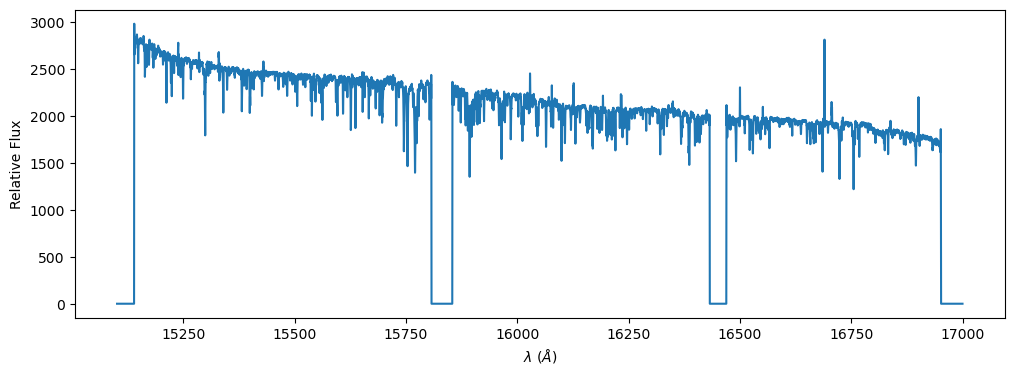

In [3]:
plt.figure(figsize=(12,4))
plt.plot(dataset.wave, dataset.flux[123])
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('Relative Flux')

In [4]:
dataset_norm = alias.continuum_normalize(dataset)

Text(0, 0.5, 'Relative Flux (Normalized)')

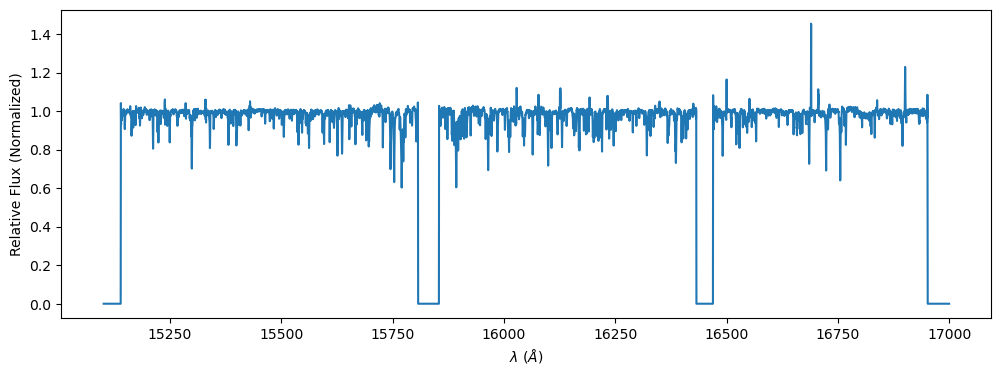

In [5]:
plt.figure(figsize=(12,4))
plt.plot(dataset_norm.wave, dataset_norm.flux[123])
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('Relative Flux (Normalized)')

In [6]:
dataset_residuals = alias.get_residuals(dataset_norm)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0, 0.5, 'Relative Flux (Normalized)')

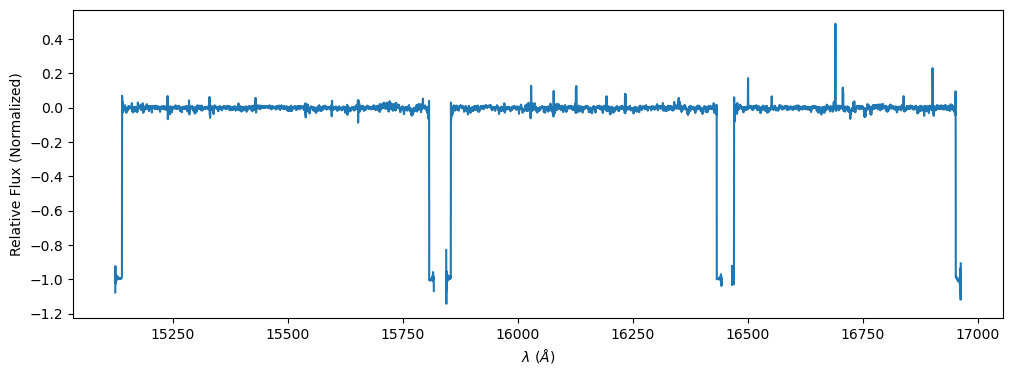

In [7]:
plt.figure(figsize=(12,4))
plt.plot(dataset_norm.wave, dataset_residuals.flux[123])
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('Relative Flux (Normalized)')

In [8]:
crossing_events = alias.detect_all(dataset_residuals)

print(np.shape(crossing_events))

(53148, 2)


In [9]:
import tqdm.notebook as tqdm
characteristics = alias.characterize_all(dataset_residuals, tqdm.tqdm(crossing_events))

  0%|          | 0/53148 [00:00<?, ?it/s]

/mnt_home/jhand/alias/alias/__init__.py:187: RuntimeWarning: divide by zero encountered in power
  chi2 = [ _chi2_lsf(flux, ivar**-0.5, default_lsf.x, np.array(default_lsf.y), 0.3, center) for center in center_idx ]
/mnt_home/jhand/alias/alias/__init__.py:196: RuntimeWarning: divide by zero encountered in power
  _chi2_lsf(flux, ivar**-0.5, default_lsf.x, np.array(default_lsf.y), amp, best_idx)


In [10]:
crossing_events = characteristics

Text(0, 0.5, 'Relative Flux (Normalized)')

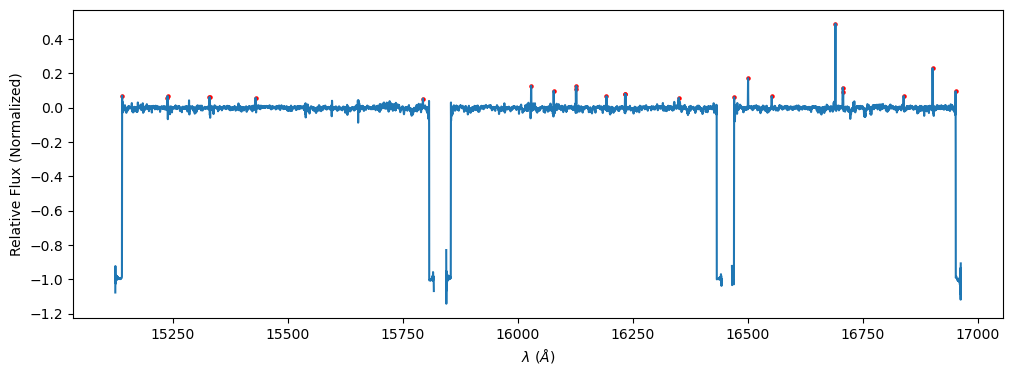

In [12]:
plt.figure(figsize=(12,4))
plt.plot(dataset_norm.wave, dataset_residuals.flux[123])
plt.scatter(
    dataset_norm.wave[np.array(crossing_events[crossing_events[:,0]==123,1],dtype=int)],
    dataset_residuals.flux[123,np.array(crossing_events[crossing_events[:,0]==123,1],dtype=int)],
    color='red', s=5
)
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('Relative Flux (Normalized)')

In [14]:
hist = np.array([0]*len(dataset_norm.wave))
hist_partial = np.bincount(np.array(crossing_events[:,1], dtype=int))

hist[0:len(hist_partial)] = hist_partial

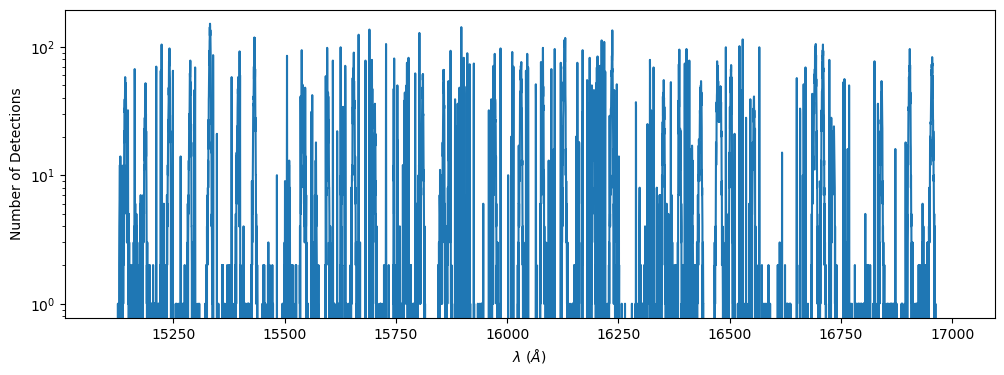

In [15]:
plt.figure(figsize=(12,4))

plt.plot(dataset_norm.wave, hist)
plt.yscale('log')

plt.xlabel(r'$\lambda$ ($\AA$)')
_ = plt.ylabel('Number of Detections')

In [16]:
def classify(classes, mask, bit):
    classes[mask] = np.bitwise_or(classes[mask], 1 << bit)

In [46]:
classifications = np.array([0] * len(crossing_events), dtype=int)

# Not unique
classify(classifications, hist[np.array(crossing_events[:,1],dtype=int)] > 2, 0)

# Not wide enough
classify(classifications, np.array(crossing_events[:,4]) < 0.7, 1)

# Not tall enough
classify(classifications, np.array(crossing_events[:,3]) < 0.1, 2)

In [47]:
np.sum(classifications == 0)

80

In [48]:
candidates = characteristics[classifications == 0]

[1.09900000e+03 8.27300000e+03 1.69291626e+04 2.28032044e-01
 8.66243117e-01]


(0.4, 1.4)

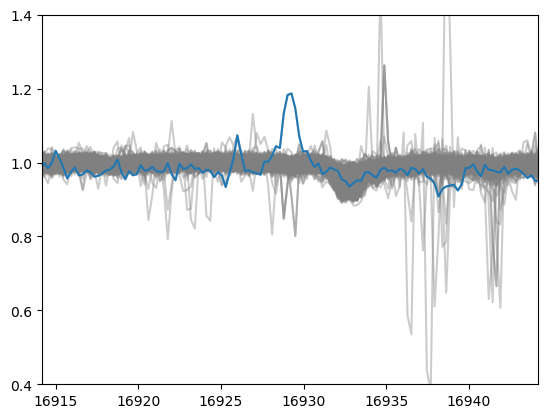

In [145]:
cid = 73

print(candidates[cid])

spec_id = int(candidates[cid,0])

plt.plot(dataset_norm.wave, dataset_norm.flux[:].T, color='gray', alpha=0.4)
plt.plot(dataset_norm.wave, dataset_norm.flux[spec_id])

plt.xlim(candidates[cid,2] - 15, candidates[cid,2] + 15)
plt.ylim(0.4,1.4)